#1.Імпорт і формування вибірки

Імпорт необхідних бібліотек

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from zipfile import ZipFile
import PIL.Image
import os
import random
import scipy.stats as st
from sklearn.metrics import mean_squared_error

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
#generating random 250 numbers 
 #rand_nums=[]
 #random.seed(1)
 #for i in range(251):
  # n = random.randint(1, 25000)
  # rand_nums.append(n)

#extracting images from archive into google drive
 #def extractImgs(nums):
  # archive=ZipFile('/content/drive/My Drive/mirflickr25k.zip', 'r')
   #for i in nums:
    # path='mirflickr/im'+str(i)+'.jpg'
    # archive.extract(path, '/content/drive/My Drive/')
  # archive.close()

 #extractImgs(rand_nums)

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
#converting images to arrays and appending them into list
def getImgs(path):
  imgs=[] 
  for img in os.listdir(path):
    imgs.append(np.array(PIL.Image.open(path+img)))
    
  return np.asarray(imgs)

imgs= getImgs('/content/drive/My Drive/mirflickr/')
print('Sampled {} RGB-images'.format(len(imgs)))

Sampled 250 RGB-images


# 2. Характеристики розподілу для зеленого каналу

Формування масиву, що містить значення яскравості пікселів зеленого каналу всієї вибірки зображень, а також двохвимірного масиву, що містить в собі масиви значень яскравості пікселів зеленого каналу кожного зображення.

In [0]:
#green_values contains green-pixel-intensities of all sample 
green_all = []
green_img_list=[]
for i in range(len(imgs)):
  img = imgs[i].flatten()
  n = len(img)
  k=len(green_all)
  for green in range(1, n, 3):
    green_all.append(img[green])
  green_img_list.append(np.array(green_all[k:k+int(np.floor(n/3))]))

green_all = np.array(green_all)
green_img_list = np.array(green_img_list)

In [0]:
green_img_binned_list =[]
green_all_binned = np.bincount(green_all)
for green_img in green_img_list:
  green_img_binned_list.append(np.bincount(green_img))

Математичне очікування та дисперсія

In [9]:
expect_green = np.mean(green_all)
var_green = np.var(green_all)
print('Expected value and variance of pixel intensity of green channel of all 250 images are {} and {} respectively'.format(expect_green, var_green))

Expected value and variance of pixel intensity of green channel of all 250 images are 104.32698693938991 and 5572.828828999129 respectively


Медіана та інтерквартальний розмах

In [10]:
median_green = np.median(green_all)

q75, q25 = np.percentile(green_all, [75 ,25])
iqr_green = q75 - q25
print('Median and interquartile range of pixel intensity of green channel of all 250 images are {} and {} respectively'.format(median_green, iqr_green))

Median and interquartile range of pixel intensity of green channel of all 250 images are 97.0 and 123.0 respectively


Отже, значення, що лежать на відстані, більшій ніж півтора інтерквартильних діапазона від 1-го або ж 3-го квартиля, вважаються викидами. Проте розрахунки нижче вказують на те, що таких немає, оскільки q25-1.5iqr<0, а q75+1.5iqr>255.

In [11]:
print('We consider pixel intensity values to be outliers if they are below {} or above {}, but the values are far beyond valid range for pixel intensity.'.format(q25-1.5*iqr_green, q75+1.5*iqr_green))

We consider pixel intensity values to be outliers if they are below -146.5 or above 345.5, but the values are far beyond valid range for pixel intensity.


Коефіцієнти асиметрії та ексцесу (нормалізований)

In [12]:
skew_green = st.skew(green_all)
kurt_green = st.kurtosis(green_all)-3
print('Skewness and normalized kurtosis of pixel intensity of green channel of all 250 images are {} and {} respectively'.format(skew_green, kurt_green))

Skewness and normalized kurtosis of pixel intensity of green channel of all 250 images are 0.32621085086243945 and -3.9947769281332453 respectively



Нормалізована гістограма значень яскравості пікселів

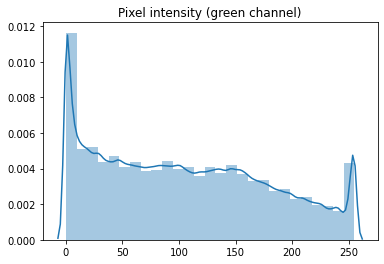

In [13]:

plt.title('Pixel intensity (green channel)')
sns.distplot(green_all, bins=27, norm_hist = True)

#3.Обробка отриманих гістограм

##a. Апроксимація гістограми

Результати апроксимації гістограми вибірки всіх значень яскравості пікселів кривими нормального, Лапласового, Стьюдентового та бета-розподілу наведені у вигляді графіків нижче.

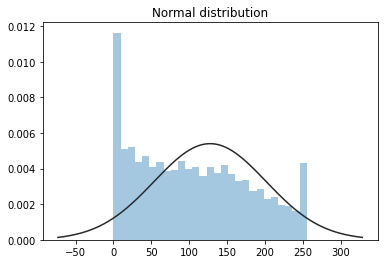

In [14]:
plt.title("Normal distribution")
sns.distplot(np.arange(256), bins=27, hist_kws={'weights':green_all_binned},norm_hist=True,fit=st.norm,kde=False) 

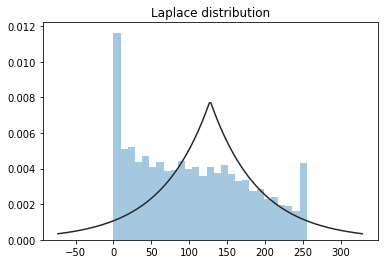

In [15]:
plt.title("Laplace distribution")
sns.distplot(np.arange(256), bins=27, hist_kws={'weights':green_all_binned},norm_hist=True,fit=st.laplace,kde=False) 

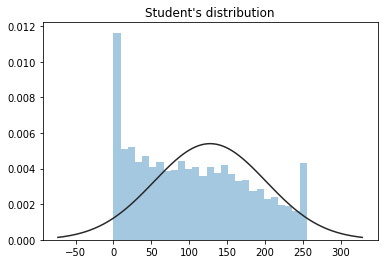

In [16]:
plt.title("Student's distribution")
sns.distplot(np.arange(256), bins=27, hist_kws={'weights':green_all_binned},norm_hist=True,fit=st.t,kde=False) 

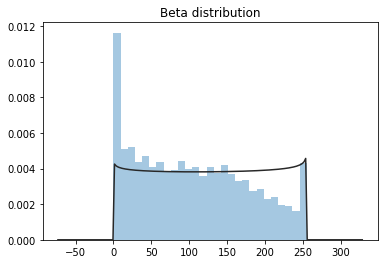

In [17]:
plt.title("Beta distribution")
sns.distplot(np.arange(256), bins=27, hist_kws={'weights':green_all_binned},norm_hist=True,fit=st.beta,kde=False) 



##b. Визначення найкращого типу апроксимуючого розподілу за критерієм мінімізації середньо квадратичного відхилення.




In [0]:
def get_dist(dist):
    bincount = np.bincount(dist)
    pixels_value_counts = np.zeros(256,dtype=int)
    pixels_value_counts[:bincount.shape[0]] = bincount
    b_dist = pixels_value_counts
    lin_space = np.linspace(0,255,num=256)
    norm = st.norm.pdf(lin_space,*st.norm.fit(b_dist))
    laplace = st.laplace.pdf(lin_space,*st.laplace.fit(b_dist))
    t = st.t.pdf(lin_space,*st.t.fit(b_dist))
    beta = st.beta.pdf(lin_space,*st.beta.fit(b_dist))
    mse = {'norm': mean_squared_error(b_dist,norm*b_dist.sum()), 
           'laplace': mean_squared_error(b_dist,laplace*b_dist.sum()),
           'student': mean_squared_error(b_dist,t*b_dist.sum()), 
           'beta': mean_squared_error(b_dist,beta*b_dist.sum())}
    return (min(mse, key=lambda x: mse[x]),mse[min(mse, key=lambda k: mse[k])])
best_dists = [get_dist(x.flatten()) for x in green_img_list]

In [22]:
for i,d in enumerate(best_dists):
    print(f'Image {i} best distribution {d[0]}')

Image 0 best distribution student
Image 1 best distribution beta
Image 2 best distribution norm
Image 3 best distribution beta
Image 4 best distribution norm
Image 5 best distribution laplace
Image 6 best distribution laplace
Image 7 best distribution laplace
Image 8 best distribution student
Image 9 best distribution laplace
Image 10 best distribution laplace
Image 11 best distribution student
Image 12 best distribution norm
Image 13 best distribution norm
Image 14 best distribution beta
Image 15 best distribution student
Image 16 best distribution student
Image 17 best distribution student
Image 18 best distribution student
Image 19 best distribution norm
Image 20 best distribution student
Image 21 best distribution beta
Image 22 best distribution beta
Image 23 best distribution beta
Image 24 best distribution laplace
Image 25 best distribution beta
Image 26 best distribution laplace
Image 27 best distribution laplace
Image 28 best distribution beta
Image 29 best distribution beta
Im

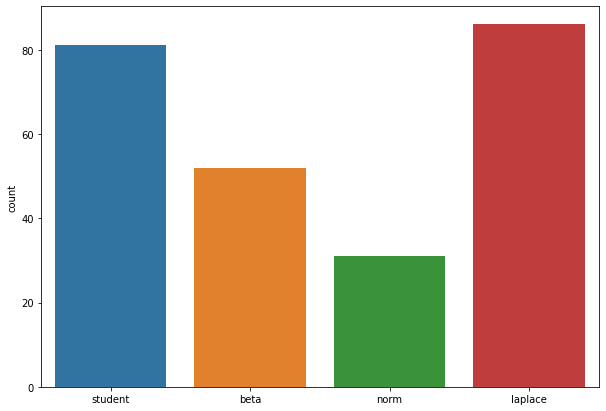

In [26]:
plt.figure(figsize=(10,7))
sns.countplot([x[0] for x in best_dists]);

#4.Багатовимірні гаусові моделі


і) математичне очікування:

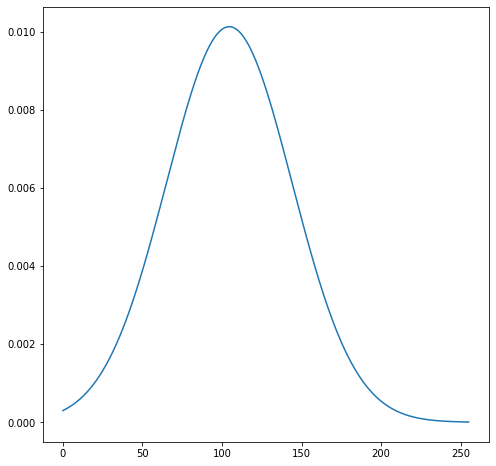

In [50]:
mean = [np.mean(x) for x in green_img_list]
vec_mean = np.mean(mean)
cov = np.cov(mean)
x = np.linspace(0,255,5100)
y = st.norm.pdf(x,vec_mean,cov**0.5)

plt.figure(figsize=(8,8))
plt.plot(x,y)

In [51]:
print("mean: ", vec_mean)
print("cov: ", cov)

mean:  104.55681374933789
cov:  1552.6609550619742


іі) математичне очікування та дисперсія:

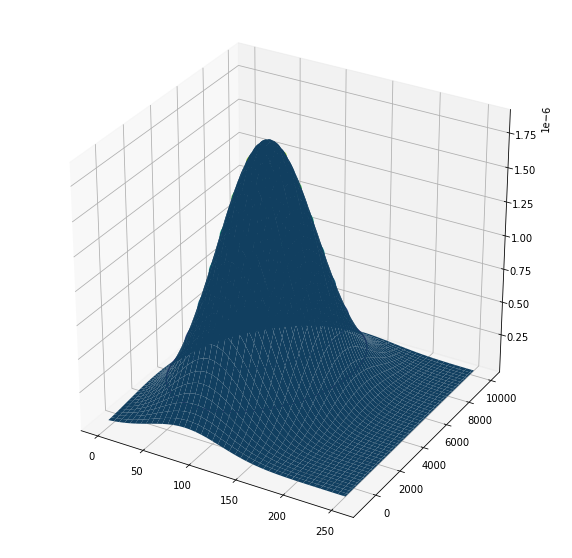

In [52]:
var = [np.var(x) for x in green_img_list]
temp = np.vstack((mean,var))
vec_mean = np.mean(temp,axis=1)
cov = np.cov(temp)
x,y = np.mgrid[0:255, -1000:10000]
space = np.empty(x.shape+(2,))
space[:,:,0]=x
space[:,:,1]=y
z = st.multivariate_normal.pdf(space,vec_mean,cov)
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')
ax.plot_surface(x,y,z)
plt.contour(x,y,z)
plt.show()

In [54]:
print("mean: ", vec_mean)
print("cov: ", cov)
print("var: ", var)

mean:  [ 104.55681375 4041.70367757]
cov:  [[1.55266096e+03 1.97717851e+04]
 [1.97717851e+04 4.87940131e+06]]
var:  [5136.5264037355555, 4333.981898879636, 3067.018352015626, 4764.527460079458, 2725.1529912944, 5318.902130457255, 5033.296705398869, 5187.1397699206955, 1855.469658932181, 6996.028107606784, 5018.844437524949, 2424.8599476542563, 5177.341411356546, 4693.633035322694, 3175.0823869463698, 1658.2932540384993, 1498.8732678193762, 4619.065265035646, 2365.5175767127034, 5254.023694960525, 2010.68711207911, 4071.8249394051845, 3014.2517391797765, 4163.925431246772, 4373.554152258601, 2674.519460466336, 1113.2175567308618, 2284.442120679238, 5056.376603640441, 4828.05203292862, 2865.7963007944695, 7576.9234999260725, 1636.0373331207984, 4990.02029229783, 6608.199985791288, 5478.180496948805, 2346.8666127180295, 1741.5698269539803, 5244.16030568266, 3145.3974310797826, 6037.753721795165, 4005.6956768054333, 2433.9818349051448, 1618.009761441838, 5794.361462505064, 6210.92206347594

ііі) математичне очікування, дисперсія та коефіцієнт асиметрії:

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  if sys.path[0] == '':


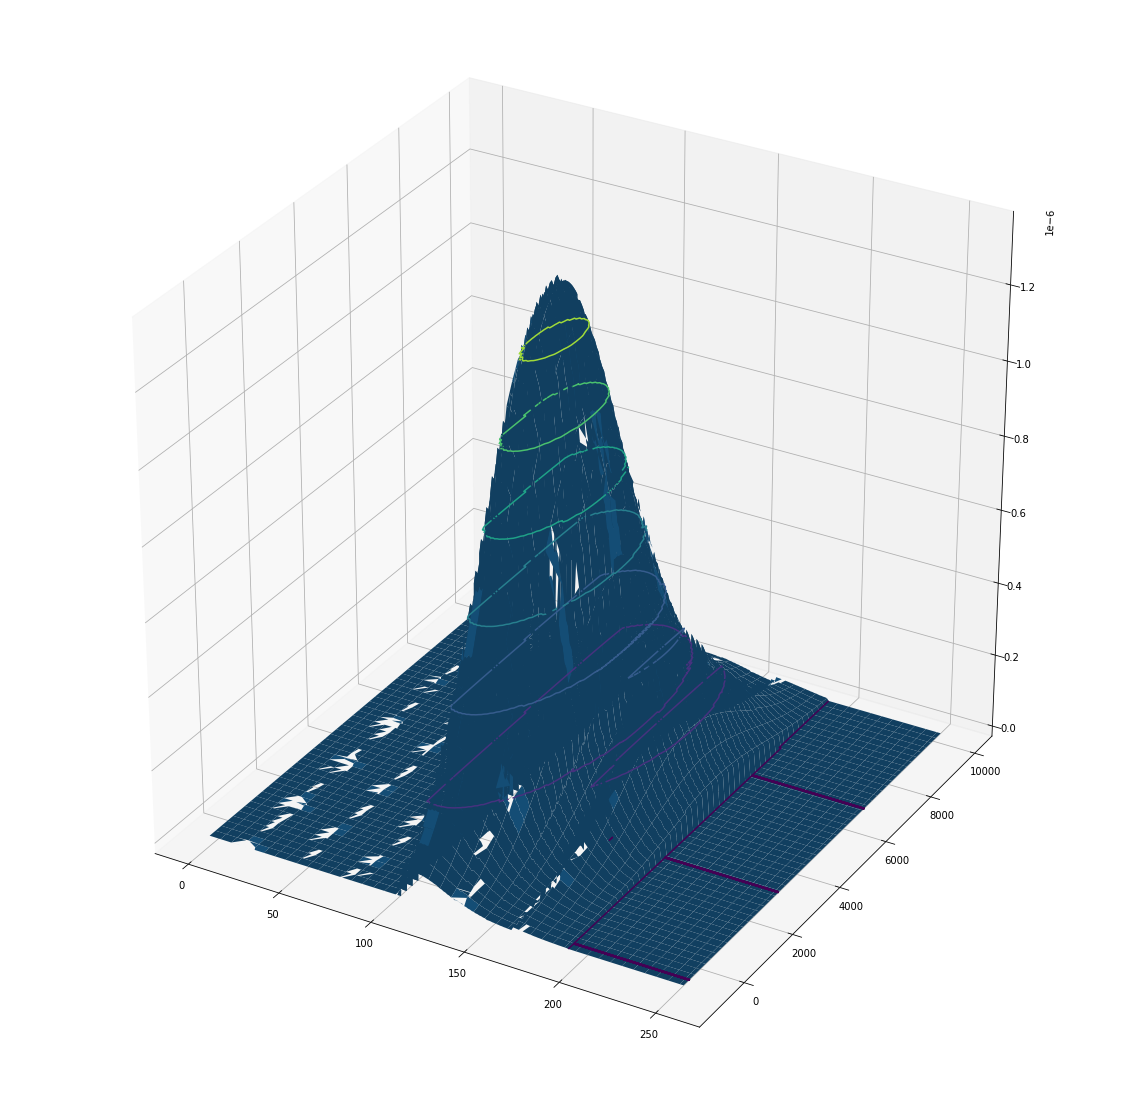

In [60]:
skew = [st.skew(x.flatten()) for x in green_img_list]
temp = np.vstack((mean,var,skew))
vec_mean = np.mean(temp,axis=1)
cov = np.cov(temp)
x,y = np.mgrid[0:255, -1000:10000]
space = np.empty(x.shape+(3,))
space[:,:,0]=x
space[:,:,1]=y
z = st.multivariate_normal.pdf(space,vec_mean,cov)
fig = plt.figure(figsize=(20,20))
ax = fig.gca(projection='3d')
ax.plot_surface(x,y,z)
plt.contour(x,y,z)
plt.show()

In [56]:
print("mean: ", vec_mean)
print("cov: ", cov)
print("var: ", var)
print("skew: ", skew)

mean:  [1.04556814e+02 4.04170368e+03 3.72161389e-01]
cov:  [[ 1.55266096e+03  1.97717851e+04 -3.33604262e+01]
 [ 1.97717851e+04  4.87940131e+06 -3.61346551e+02]
 [-3.33604262e+01 -3.61346551e+02  9.82485690e-01]]
var:  [5136.5264037355555, 4333.981898879636, 3067.018352015626, 4764.527460079458, 2725.1529912944, 5318.902130457255, 5033.296705398869, 5187.1397699206955, 1855.469658932181, 6996.028107606784, 5018.844437524949, 2424.8599476542563, 5177.341411356546, 4693.633035322694, 3175.0823869463698, 1658.2932540384993, 1498.8732678193762, 4619.065265035646, 2365.5175767127034, 5254.023694960525, 2010.68711207911, 4071.8249394051845, 3014.2517391797765, 4163.925431246772, 4373.554152258601, 2674.519460466336, 1113.2175567308618, 2284.442120679238, 5056.376603640441, 4828.05203292862, 2865.7963007944695, 7576.9234999260725, 1636.0373331207984, 4990.02029229783, 6608.199985791288, 5478.180496948805, 2346.8666127180295, 1741.5698269539803, 5244.16030568266, 3145.3974310797826, 6037.7537

іv) математичне очікування, дисперсія, коефіцієнт асиметрії та ексцесу:

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  if sys.path[0] == '':


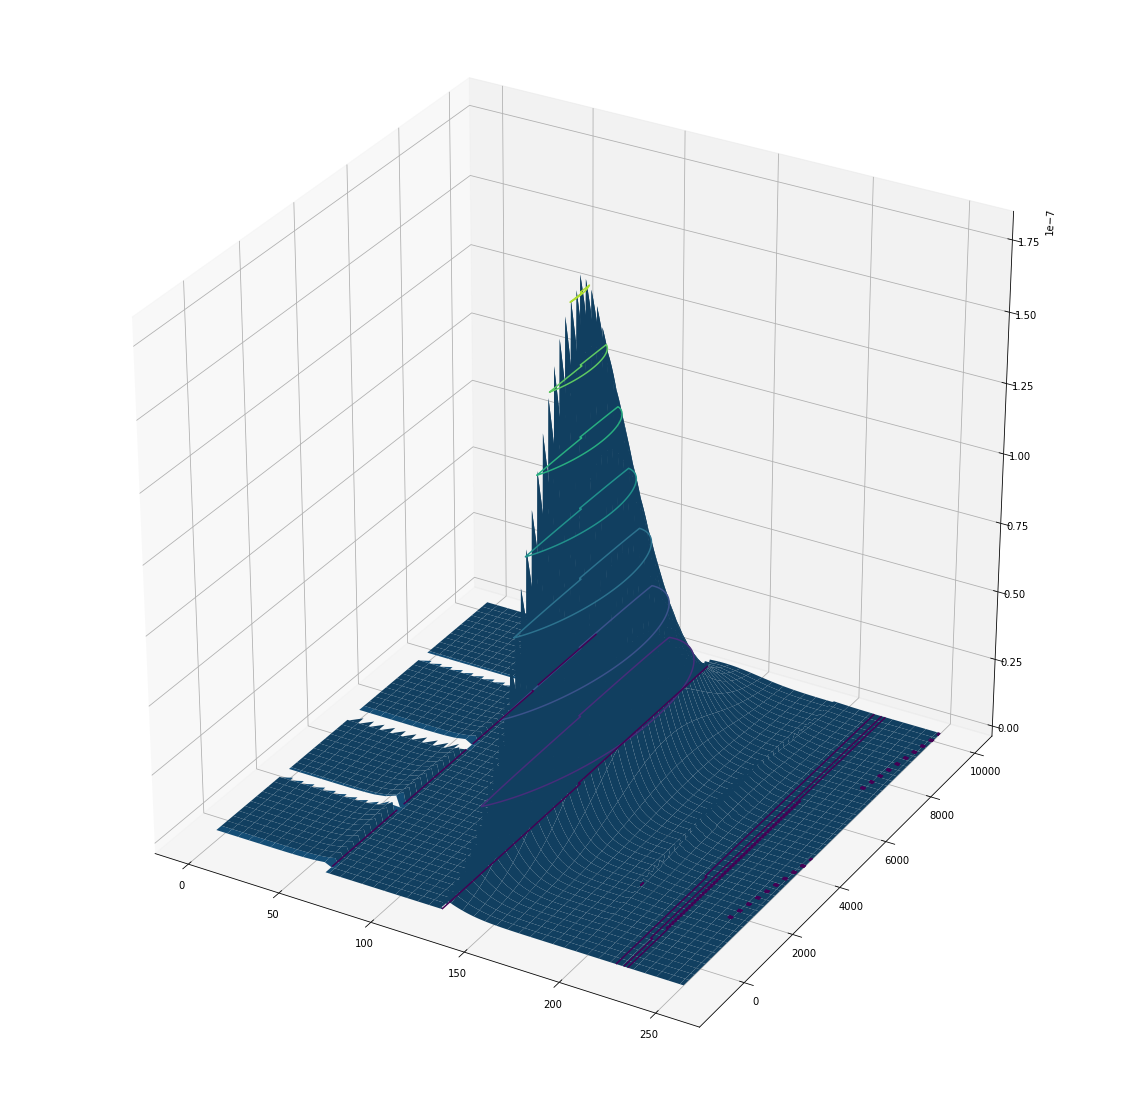

In [59]:
kurtosis = [st.kurtosis(x.flatten()) for x in green_img_list]
temp = np.vstack((mean,var,skew,kurtosis))
vec_mean = np.mean(temp,axis=1)
cov = np.cov(temp)
x,y = np.mgrid[0:255, -1000:10000]
space = np.empty(x.shape+(4,))
space[:,:,0]=x
space[:,:,1]=y
z = st.multivariate_normal.pdf(space,vec_mean,cov)
fig = plt.figure(figsize=(20,20))
ax = fig.gca(projection='3d')
ax.plot_surface(x,y,z)
plt.contour(x,y,z)
plt.show()

In [58]:
print("mean: ", vec_mean)
print("cov: ", cov)
print("var: ", var)
print("skew: ", skew)
print("kurtosis: ", kurtosis)

mean:  [1.04556814e+02 4.04170368e+03 3.72161389e-01 3.93080073e-01]
cov:  [[ 1.55266096e+03  1.97717851e+04 -3.33604262e+01 -6.48548763e+01]
 [ 1.97717851e+04  4.87940131e+06 -3.61346551e+02 -3.17102390e+03]
 [-3.33604262e+01 -3.61346551e+02  9.82485690e-01  2.44847517e+00]
 [-6.48548763e+01 -3.17102390e+03  2.44847517e+00  1.53996440e+01]]
var:  [5136.5264037355555, 4333.981898879636, 3067.018352015626, 4764.527460079458, 2725.1529912944, 5318.902130457255, 5033.296705398869, 5187.1397699206955, 1855.469658932181, 6996.028107606784, 5018.844437524949, 2424.8599476542563, 5177.341411356546, 4693.633035322694, 3175.0823869463698, 1658.2932540384993, 1498.8732678193762, 4619.065265035646, 2365.5175767127034, 5254.023694960525, 2010.68711207911, 4071.8249394051845, 3014.2517391797765, 4163.925431246772, 4373.554152258601, 2674.519460466336, 1113.2175567308618, 2284.442120679238, 5056.376603640441, 4828.05203292862, 2865.7963007944695, 7576.9234999260725, 1636.0373331207984, 4990.02029229